# Нейросеть СNN  для распознавания тематики книги по обложке

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import re
from random import shuffle
from glob import glob

from sklearn.metrics import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams

#список всех файлов изображений для анализа
all_files = glob('allfiles\\*.jpg')

In [3]:
all_f = []
for i in all_files:
    all_f.append(i.replace('allfiles'+'\\',''))
ff = pd.DataFrame(all_f, columns=['fname'])

ff - датафрейм чтобы проверить, что есть все файлы из загруженной таблицы; пустые записи удалим.

загрузим заранее подготовленный файл с классами и номером изображения

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

df = pd.read_csv('title_cover.csv')
df['path'] = df.file.apply(lambda x: 'allfiles'+'\\'+x )
df.head()

,children,fantasy,medicine,music,mystery and detective stories,recipes,religion,romance,science,science fiction,cover_id,file,path
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575546.0,575546.jpg,allfiles\575546.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981419.0,1981419.jpg,allfiles\1981419.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905279.0,905279.jpg,allfiles\905279.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321813.0,1321813.jpg,allfiles\1321813.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964863.0,2964863.jpg,allfiles\2964863.jpg


In [5]:
books = df.merge(ff, left_on='file', right_on='fname', how='inner') 
# inner,  чтобы взять те файлы, которые точно есть и папке с файлами и в df

In [6]:
books.head()

,children,fantasy,medicine,music,mystery and detective stories,recipes,religion,romance,science,science fiction,cover_id,file,path,fname
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575546.0,575546.jpg,allfiles\575546.jpg,575546.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981419.0,1981419.jpg,allfiles\1981419.jpg,1981419.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905279.0,905279.jpg,allfiles\905279.jpg,905279.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321813.0,1321813.jpg,allfiles\1321813.jpg,1321813.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964863.0,2964863.jpg,allfiles\2964863.jpg,2964863.jpg


In [7]:
books.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41279 entries, 0 to 41278
Data columns (total 14 columns):
children                         41279 non-null float64
fantasy                          41279 non-null float64
medicine                         41279 non-null float64
music                            41279 non-null float64
mystery and detective stories    41279 non-null float64
recipes                          41279 non-null float64
religion                         41279 non-null float64
romance                          41279 non-null float64
science                          41279 non-null float64
science fiction                  41279 non-null float64
cover_id                         41279 non-null float64
file                             41279 non-null object
path                             41279 non-null object
fname                            41279 non-null object
dtypes: float64(11), object(3)
memory usage: 4.7+ MB


In [8]:
books[subj_list].sum()

children                         2251.0
fantasy                          3815.0
medicine                         1324.0
music                            3180.0
mystery and detective stories    1713.0
recipes                             7.0
religion                         7570.0
romance                          9736.0
science                          9271.0
science fiction                  3171.0
dtype: float64

In [9]:
# оказалось, что изображений рецептов всего 7. Исключим их из анализа
subj_new = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'religion', 'romance', 'science','science fiction']

In [10]:
books.drop_duplicates(inplace= True) # исключим дублированные записи

In [11]:
# матрицы train/test
X = books['path']
y = books[subj_new]

In [12]:
# Создаем train/test в отношении 90/10, тк изображения тем сильно отличаются в пределах класса. 
# При тренировке есть желание показать модели как можно больше вариантов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, shuffle = True)

In [13]:
# Преобразуем данные в удобную форму для сети
Xtr, Xtst, ytr, ytst = list(np.array(X_train)), list(np.array(X_test)), np.array(y_train), np.array(y_test)

In [14]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [15]:
# генераторы последовательного чтения данных
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для ResNet50

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, yy ,  batch_size = 32):    
    while True:
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)               
                
            x = np.array([load_image(path) for path in files[i:j]])
            y = yy[i:j]
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

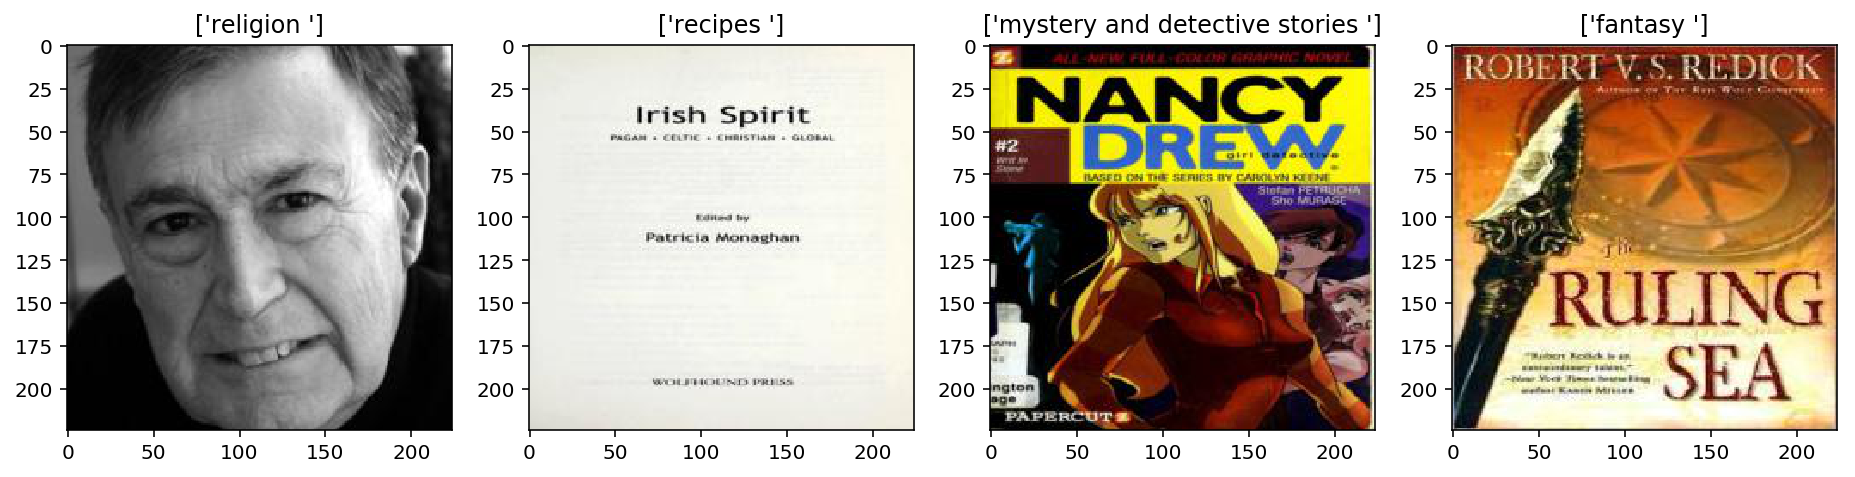

In [16]:
#Изобразим некоторые обложки
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    #print(Xtr[i])
    book_title = []
    for j in range(0,  9):
        if ytr[i][j] !=0:
            book_title.append(subj_list[j]+' ')        
    subplot.set_title('%s' %  str(book_title)); # вывод названия жанра    
plt.show()

In [17]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = True,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [18]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:    
    layer.trainable = False

In [19]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [20]:
x = base_model.output 
x = keras.layers.Dropout(0.3) (x)
x = keras.layers.Dense(150, activation = 'relu') (x) 
x = keras.layers.Dense(9,  # 9 выходов осталось 9 классов
                activation='sigmoid',  # функция активации  
                )(x) 
model = Model(inputs=base_model.input, outputs=x)

In [21]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
checkp = ModelCheckpoint(filepath='weights.best.cover.hdf5', 
                               verbose=1, save_best_only=True)

In [22]:
train_val_split = 32  # число изображений в валидационной выборке
validation_data = next(fit_generator(Xtr[:train_val_split],ytr[:train_val_split], train_val_split))

In [23]:
# запускаем процесс обучения
model.fit_generator(fit_generator(Xtr[train_val_split:], ytr[train_val_split:], train_val_split),  # данные читаем функцией-генератором
        steps_per_epoch=1300,  # число вызовов генератора за эпоху
        epochs=2,# число эпох обучения
        validation_data=validation_data, callbacks = [checkp], shuffle = True)

Epoch 1/2
1299/1300 [============================>.] - ETA: 0s - loss: 0.3187 - acc: 0.8900
Epoch 00001: val_loss improved from inf to 0.32362, saving model to weights.best.cover.hdf5
1300/1300 [==============================] - 183s 140ms/step - loss: 0.3187 - acc: 0.8900 - val_loss: 0.3236 - val_acc: 0.8750
Epoch 2/2
1299/1300 [============================>.] - ETA: 0s - loss: 0.2824 - acc: 0.8954
Epoch 00002: val_loss did not improve
1300/1300 [==============================] - 178s 137ms/step - loss: 0.2824 - acc: 0.8954 - val_loss: 0.3425 - val_acc: 0.8785


In [53]:
model.load_weights('weights.best.cover.hdf5')

In [24]:
%%time
pred = model.predict_generator(predict_generator(Xtst), len(ytst), max_queue_size=100)

Wall time: 58.5 s


In [25]:
pred

array([[6.6514961e-02, 1.2329202e-04, 6.8710618e-02, ..., 4.7172070e-05,
        9.6905810e-01, 1.7587382e-04],
       [7.0305496e-02, 4.4430772e-04, 7.0963040e-02, ..., 2.8430481e-04,
        9.4949943e-01, 5.0373876e-04],
       [7.3076420e-02, 9.3987893e-04, 6.7184977e-02, ..., 4.5623476e-04,
        8.7514412e-01, 1.3685647e-03],
       ...,
       [5.4084767e-02, 7.3177993e-02, 5.2737802e-02, ..., 5.1856805e-02,
        1.8069996e-01, 1.2786390e-01],
       [6.8609402e-02, 3.3494210e-04, 6.6458419e-02, ..., 1.3192733e-04,
        9.3854171e-01, 4.9565692e-04],
       [5.3824995e-02, 1.9037187e-01, 2.0793254e-02, ..., 4.3220580e-01,
        3.1505674e-02, 2.6610264e-01]], dtype=float32)

Как видим, полученный ответ явно не дает информацию преобладающих классах, поэтому
предстоит обработать полученный ответ.

In [26]:
y_pred = np.around(np.array(pred), decimals=3)
y_pred[-10:]

array([[0.072, 0.   , 0.071, 0.176, 0.002, 0.209, 0.   , 0.943, 0.   ],
       [0.031, 0.107, 0.038, 0.077, 0.025, 0.264, 0.06 , 0.166, 0.337],
       [0.044, 0.237, 0.012, 0.042, 0.126, 0.092, 0.695, 0.009, 0.375],
       [0.067, 0.106, 0.025, 0.047, 0.077, 0.127, 0.481, 0.044, 0.152],
       [0.094, 0.003, 0.082, 0.144, 0.008, 0.227, 0.005, 0.784, 0.007],
       [0.026, 0.071, 0.006, 0.018, 0.035, 0.049, 0.877, 0.015, 0.036],
       [0.089, 0.204, 0.015, 0.109, 0.354, 0.032, 0.05 , 0.074, 0.34 ],
       [0.054, 0.073, 0.053, 0.117, 0.03 , 0.223, 0.052, 0.181, 0.128],
       [0.069, 0.   , 0.066, 0.166, 0.002, 0.201, 0.   , 0.939, 0.   ],
       [0.054, 0.19 , 0.021, 0.059, 0.097, 0.112, 0.432, 0.032, 0.266]],
      dtype=float32)

In [27]:
# возможные пороги 
threshold = np.arange(0.1,0.9,0.1)
threshold

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [28]:
# рассчет индивидуального порога для каждого класса
from sklearn.metrics import *
acc = []
accuracies = []
best_threshold = np.zeros(ytst.shape[1])
for i in range(ytst.shape[1]):
    y_prob = np.array(pred[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(ytst[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [29]:
# сигнальные пороги для каждого класса, когда считать собитие принадлежащим классу.
best_threshold

array([0.1, 0.1, 0.1, 0.5, 0.2, 0.2, 0.3, 0.3, 0.2])

In [30]:
y_preds = np.array([[1 if pred[i,j]>=best_threshold[j] else 0 
                    for j in range(ytst.shape[1])] for i in range(len(ytst))])

In [31]:
# матрица предсказаний
y_preds

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]])

In [32]:
# ground truth, верные данные
ytst

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [33]:
# показывает качество классификатора
hamming_loss(ytst,y_preds)

0.20949074074074073

In [34]:
summary = classification_report(ytst,y_preds)
print(summary)

             precision    recall  f1-score   support

          0       0.08      0.19      0.11       194
          1       0.18      0.67      0.28       381
          2       0.13      0.02      0.04       131
          3       1.00      0.04      0.07       310
          4       0.17      0.36      0.23       181
          5       0.30      0.41      0.35       765
          6       0.38      0.47      0.42       958
          7       0.36      0.73      0.48       939
          8       0.17      0.60      0.27       336

avg / total       0.34      0.48      0.34      4195



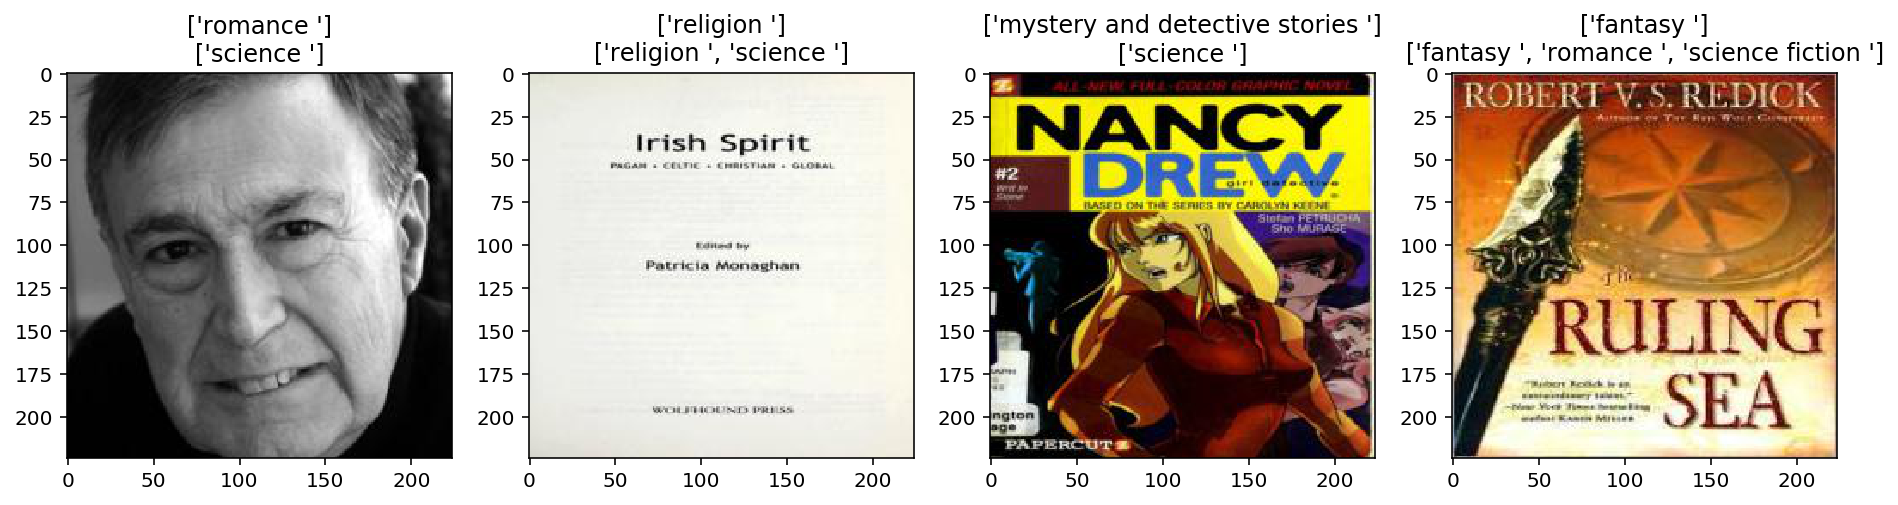

In [35]:
#Изобразим некоторые обложки
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    #print(Xtr[i])
    book_title = []
    book_title_preds = []
    for j in range(0,  9):
        if ytr[i][j] !=0:
            book_title.append(subj_new[j]+' ') 
        if y_preds[i][j] != 0:
            book_title_preds.append(subj_new[j]+' ') 
    subplot.set_title(str(book_title) + '\n' + str(book_title_preds)); # вывод названия жанра    
plt.show()

Низкое качество объясняется неравновесным количеством данных. Сложность в том, что в жанрах у обложек нет общего
характерного вида иллюстраций. 

In [36]:
ytst[:,0].shape

(4128,)

In [37]:
from sklearn.metrics import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (11, 8)

In [38]:
fpr, tpr, thr, roc_auc = {}, {}, {}, {}
for i in range(0, 9):
    fpr[subj_new[i]] , tpr[subj_new[i]] , thr[subj_new[i]] = roc_curve(ytst[:,i],np.array(pred[:,i]))
    roc_auc[subj_new[i]] = auc( fpr[subj_new[i]], tpr[subj_new[i]] )

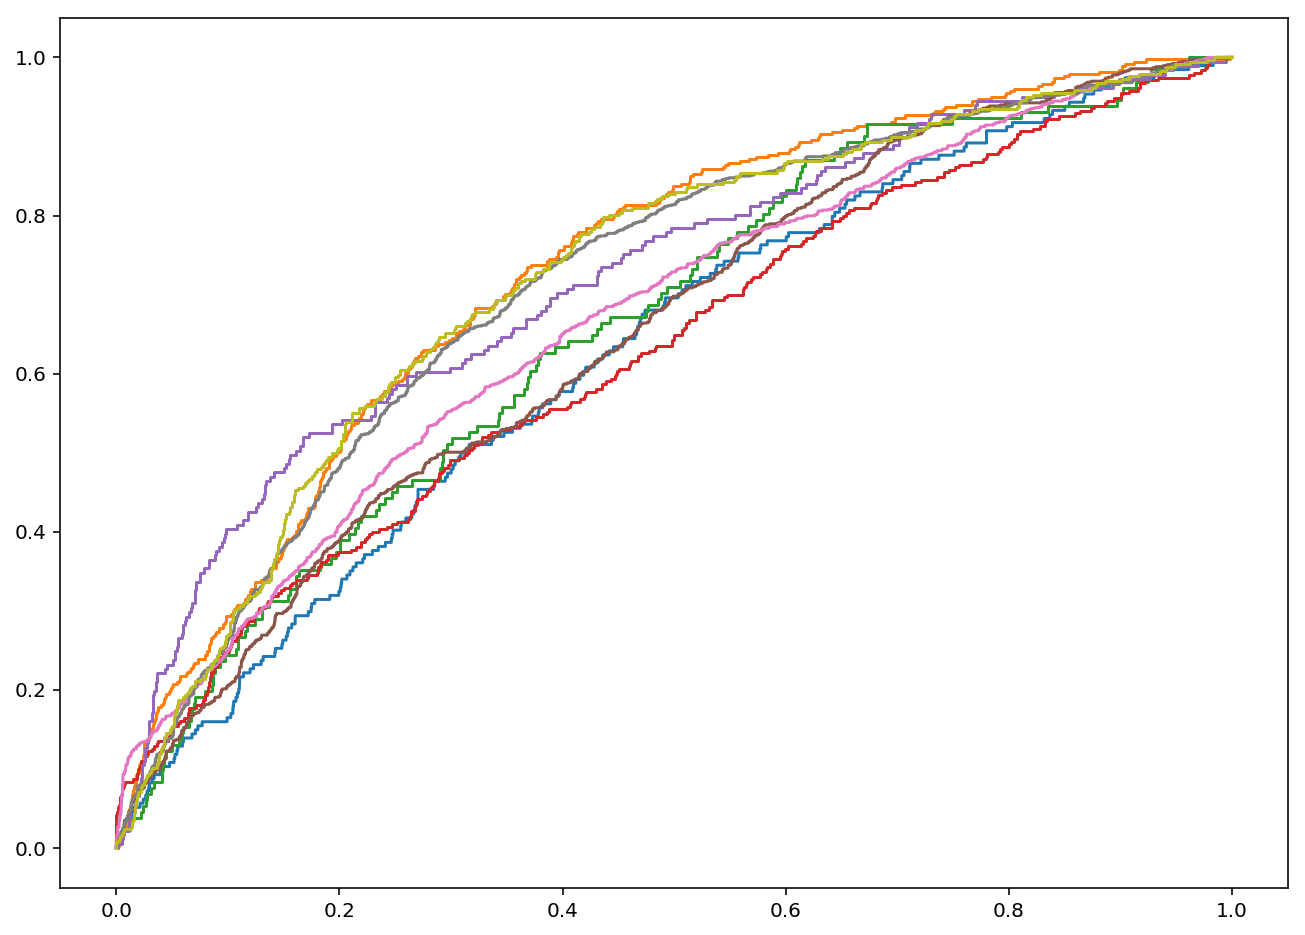

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
for subj in subj_new:
    plt.plot( fpr[subj], tpr[subj], label=subj +'. Area = {:.2f}'.format( roc_auc[subj]))  

fig = plt.figure()
plt.plot( fpr, tpr)    
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Books Cover classification')
plt.grid()
plt.show()
fig.savefig('Book Cover classification LSTM', dpi = 300, bbox_inches='tight')
print();